# Video summarization with DL embeddings (part II)

In part I of my video summarization analysis I managed to extract video frame embeddings with GoogLeNet and visualize them using T-SNE projections - the results were quite promising in a sense that projections seemed to be closer for originally similar frames

Because of that I continued with my original approach and in this part I actually performed clustering for DL embeddings - specific methods I used included K-Means with euclidean and cosine distances and Gaussian mixture models applied for original and T-SNE projected embedding vectors

Spoilers: clustering T-SNE projections tends to give random and mixed clusters (aka rubbish), standard K-Means with euclidean distance works surprisingly well (except for identifying scenes that last for ~5-10 seconds) and after doing the whole work I got the impression that the main problem in getting reasonable clusters is my inability to properly determine how many clusters videos should have (which is a great excuse to experiment with DBSCAN and mean-shift algorithms later on)

## Importing necessary libraries

In [1]:
import sys
import os.path
import youtube_dl as yt
import cv2
import numpy as np
import pandas as pd
import itertools
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import nltk.cluster

Importing necessary stuff for GoogleNet model taken from here: http://joelouismarino.github.io/blog_posts/blog_googlenet_keras.html

Note that in order to have everything working:
* The contents of zip file (googlenet_architecture.json, googlenet_weights.h5, googlenet_custom_layers.py) should be in the same folder as this jupyter notebook
* keras should be using theano backend (in C:/Users/"your_user"/.keras/keras.json" file "backend" field should be set to "theano" and "image_dim_ordering" field should be set to "th")

In [2]:
import theano
import keras
from keras import backend as K
from keras.models import model_from_json
from googlenet_custom_layers import PoolHelper,LRN

Using Theano backend.


In [3]:
from IPython.display import YouTubeVideo
from tqdm import tqdm
import matplotlib.pyplot as plt
from bokeh.charts import HeatMap
from bokeh.models import Label, Legend
from bokeh.models.widgets import Panel, Tabs
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [4]:
%matplotlib inline

## Selecting and downloading videos

In [5]:
video_ids = ["GtLtaH0s1sQ", "AspzkkQr-Ag", "_K_WmV50e7c", "aH9PwiEdW88", "AeCjApy8erc"]
true_cluster_nums = {"GtLtaH0s1sQ" : 3, "AspzkkQr-Ag" : 3, "_K_WmV50e7c" : 4, "aH9PwiEdW88" : 5, "AeCjApy8erc" : 3}

In this particular notebook my goal is to perform clustering of video frames and check how picked clusters reconcile with my understanding of what is going on in the videos - this means that I would like to pick videos with ~5 of distinct themes / scenes and check whether my approach manages to recover them

For that reason I decided to go with some short clips from Archer TV series - apart from being fun, selected videos are about ~2 minutes each so they have a reasonable amount of transitions, yet the clustering task is not really trivial because scenes are typically shown from different angles and frequently contain close ups

Giving more details about individual videos:
* "GtLtaH0s1sQ" is an Ocelot clip from S02E10 with three main parts: main characters in the office, main characters in Cheryl's home, interrogation of Pam
* "AspzkkQr-Ag" is a clip of Archer fighting Conway in S06E02 which consists of: Archer talking to Lana before fight, the actual fight, frames of Lana in the foreground and the fight in the background
* "_K_WmV50e7c" is a clip from S01E07 with Archer disarming a bomb which shows: close ups of Archer and Lana, scenes with Ray in the foreground, control room and a panel with Archer and Lana in the background, scenes with the bomb
* "aH9PwiEdW88" is a clip from S02E06 that shows a game of darts: Archer throwing darts, Cyril throwing darts, stills of the dart board, Cyril's flashback, Archer talking to Pam after the game
* "AeCjApy8erc" is a clip from S01E03 that introduces Conway: main scene in the office, Archer in a bar, Archer blowing covers of other agents

In [6]:
ydl_opts = {"outtmpl" : "Videos/%(id)s.%(ext)s", 
            "writedescription" : True,
            "writeannotations" : True,
            "writethumbnail" : True,
            "format" : "mp4"
           }

for video in video_ids:
    if not os.path.isfile("Videos/" + video + ".mp4"):
        yt.YoutubeDL(ydl_opts).download(["http://www.youtube.com/watch?v=" + video])

## Loading GoogLeNet model and generating frame embeddings

The way I load GoogLeNet model is essentially copied from part I - check it in case you need better exposition of what the code does

In [7]:
gln = model_from_json(open('googlenet_architecture.json').read(),custom_objects={"PoolHelper": PoolHelper,"LRN":LRN})
gln.load_weights('googlenet_weights.h5')

In [8]:
def get_layer_output(model, layer, X_batch):
    get_activations = theano.function([model.layers[0].input], layer.output, allow_input_downcast=True)
    layer_output = get_activations(X_batch)
    return layer_output

def gln_embedding(original_frame):
    frame = cv2.resize(original_frame, (224, 224)).astype("float64")
    frame = frame.transpose((2, 0, 1))
    frame[0, :, :] -= np.mean(frame[0, :, :])
    frame[1, :, :] -= np.mean(frame[1, :, :])
    frame[2, :, :] -= np.mean(frame[2, :, :])
    frame = np.expand_dims(frame, axis=0)
    output = get_layer_output(gln, gln.get_layer("pool5/7x7_s2"), frame)
    return output[0, :, 0, 0]

Choosing a specific video and generating DL embeddings for it - note that similar to the first notebook I cap the number of possible frames at ~1000.

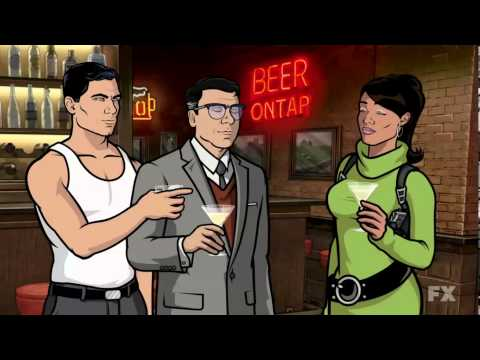

In [9]:
video_pick = 3
YouTubeVideo(video_ids[video_pick])

In [10]:
video_reader = cv2.VideoCapture("Videos/" + video_ids[video_pick] + ".mp4")
target_num_frames = 1000
sample_rate = max(1, int(video_reader.get(7) / target_num_frames))
picked_frames = range(0, int(video_reader.get(7)), sample_rate)

In [11]:
frame_embeddings = np.zeros((len(picked_frames), 1024))
embeddings_filename = "Videos/" + video_ids[video_pick] + "_embeddings.txt"

if not os.path.isfile(embeddings_filename):
    for i in tqdm(range(len(picked_frames))):
        frame_num = picked_frames[i]
        video_reader.set(1, frame_num)
        bool_flag, frame = video_reader.read()  
        frame_embeddings[i, :] = gln_embedding(frame)
    np.savetxt(embeddings_filename, frame_embeddings)
else:
    frame_embeddings = np.loadtxt(embeddings_filename)

## Clustering video frames using GoogLeNet embeddings

In general there are lots of different ways to perform clustering - as I do not know beforehand which one would work better I decided to try several approaches: starting with simple K-Means, trying K-Means with a different metric (caveat: the convergence is not guaruateed in such case), moving on to Gaussian Mixture Models and redoing these approaches for T-SNE projections of original video frame embeddings

In [12]:
np.random.seed(123456)
n_clusters = true_cluster_nums[video_ids[video_pick]]
n_images_per_cluster = 10
bokeh_plot_tabs = []
cluster_assignments = np.zeros((6, frame_embeddings.shape[0]))

As I am using several clustering approaches I would like to define a common framework to go from cluster assignment to a plot summarizing these clusters - the cell below does just that (specifically, extracts a collection of images from each cluster and pushes them to a bokeh panel)

In [13]:
def push_frame_to_bokeh_rgba(frame):
    frame = cv2.resize(frame, (75, 75))
    plot_frame = np.empty((frame.shape[0], frame.shape[1]), dtype=np.uint32)
    view = plot_frame.view(dtype=np.uint8).reshape((frame.shape[0], frame.shape[1], 4))
    view[:, :, 0] = frame[:, :, 2]
    view[:, :, 1] = frame[:, :, 1]
    view[:, :, 2] = frame[:, :, 0]
    view[:, :, 3] = 255 * np.ones((frame.shape[0], frame.shape[1]))
    view[:, :, :] = view[::-1, :]   
    return plot_frame

def get_cluster_summarization(cluster_assignment, video_reader, picked_frames, n_images_per_cluster, plot_title, tab_title):
    n_clusters = len(set(cluster_assignment))
    image_sample = np.zeros((n_clusters, n_images_per_cluster))

    for i in range(n_clusters):
        cluster_indices = np.where(cluster_assignment==i)[0]
        image_sample[i, :] = np.random.choice(cluster_indices, size=(1, n_images_per_cluster), replace=True)

    bokeh_plot = figure(tools="pan,wheel_zoom,reset,save",
                        toolbar_location="above",
                        title=plot_title,
                        width=100 * n_images_per_cluster,
                        height=100 * n_clusters,
                        x_range=(0, n_images_per_cluster),
                        y_range=(n_clusters, 0)
                       )

    for cluster_num in range(n_clusters):
        for image_num in range(n_images_per_cluster):
            frame_num = picked_frames[int(image_sample[cluster_num, image_num])]
            video_reader.set(1, frame_num)
            bool_flag, frame = video_reader.read()  
            plot_frame = push_frame_to_bokeh_rgba(frame)
            bokeh_plot.image_rgba(image=[plot_frame], x=image_num, y=cluster_num+1, dw=1, dh=1)

    return Panel(child=bokeh_plot, title=tab_title)

Finally, trying some clustering methods on original video frame embeddings

In [14]:
kmeans_model = KMeans(n_clusters, n_init=25).fit(frame_embeddings)
kmeans_clusters = kmeans_model.predict(frame_embeddings)
cluster_assignments[0, :] = kmeans_clusters
bokeh_plot_tabs.append(get_cluster_summarization(kmeans_clusters, video_reader, picked_frames, n_images_per_cluster, 
                                                 "K-Means (euclidean) clustering for video frame embeddings",
                                                 "K-Means (euclidean)"
                                                )
                      )

kmeans_cosine_model = nltk.cluster.kmeans.KMeansClusterer(n_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25)
kmeans_cosine_model.cluster_vectorspace(frame_embeddings)
kmeans_cosine_clusters = np.array([kmeans_cosine_model.classify_vectorspace(frame_embeddings[i, :]) for i in range(frame_embeddings.shape[0])])
cluster_assignments[1, :] = kmeans_cosine_clusters
bokeh_plot_tabs.append(get_cluster_summarization(kmeans_cosine_clusters, video_reader, picked_frames, n_images_per_cluster, 
                                                 "K-Means (cosine) clustering for video frame embeddings",
                                                 "K-Means (cosine)"
                                                )
                      )

gmm_model = GaussianMixture(n_clusters, n_init=25).fit(frame_embeddings)
gmm_clusters = gmm_model.predict(frame_embeddings)
cluster_assignments[2, :] = gmm_clusters
bokeh_plot_tabs.append(get_cluster_summarization(gmm_clusters, video_reader, picked_frames, n_images_per_cluster, 
                                                 "GMM clustering for video frame embeddings",
                                                 "GMM"
                                                )
                      )

Redoing these steps for t-sne projections of original frame embeddings and plotting all clusters (in the graph different rows correspond to different clusters)

In [15]:
tsne_projections = TSNE(n_components=2).fit_transform(frame_embeddings)

kmeans_tsne_model = KMeans(n_clusters, n_init=25).fit(tsne_projections)
kmeans_tsne_clusters = kmeans_tsne_model.predict(tsne_projections)
cluster_assignments[3, :] = kmeans_tsne_clusters
bokeh_plot_tabs.append(get_cluster_summarization(kmeans_tsne_clusters, video_reader, picked_frames, n_images_per_cluster, 
                                                 "K-Means (euclidean) clustering for TSNE projections of video frame embeddings",
                                                 "TSNE K-Means (euclidean)"
                                                )
                      )

kmeans_cosine_tsne_model = nltk.cluster.kmeans.KMeansClusterer(n_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25)
kmeans_cosine_tsne_model.cluster_vectorspace(tsne_projections)
kmeans_cosine_tsne_clusters = np.array([kmeans_cosine_tsne_model.classify_vectorspace(tsne_projections[i, :]) for i in range(tsne_projections.shape[0])])
cluster_assignments[4, :] = kmeans_cosine_tsne_clusters
bokeh_plot_tabs.append(get_cluster_summarization(kmeans_cosine_tsne_clusters, video_reader, picked_frames, n_images_per_cluster, 
                                                 "K-Means (cosine) clustering for TSNE projections of video frame embeddings",
                                                 "TSNE K-Means (cosine)"
                                                )
                      )

gmm_tsne_model = GaussianMixture(n_clusters, n_init=25).fit(tsne_projections)
gmm_tsne_clusters = gmm_tsne_model.predict(tsne_projections)
cluster_assignments[5, :] = gmm_tsne_clusters
bokeh_plot_tabs.append(get_cluster_summarization(gmm_tsne_clusters, video_reader, picked_frames, n_images_per_cluster, 
                                                 "GMM clustering for TSNE projections of video frame embeddings",
                                                 "TSNE GMM"
                                                )
                      )

In [16]:
tabs = Tabs(tabs=bokeh_plot_tabs)
show(tabs)

To summarize my findings from visual inspection of derived clusters: 
* It seems that clusteng for original frame embeddings allows to separate different scenes from each other provided they are distinct visually, do not have smooth transitions in between and last enough time: clear example for that is S01E07 clip (probably the best cluster splitting among all cases I considered) or "darts" cluster in S02E06 clip
* In some cases the derived clusters did not match what I expected to get but the final matching still made sense: e.g in S01E03 clip the big office scene was split in two parts that way (one cluster with closeups, another cluster with many characters in the same shot) or the fight in S0602 was split into parts where Archer is in the center of the frame and parts where it is not the case
* All approaches struggled to separate very short scenes (~5-10 seconds) despite they seemed for me to be quite different from the rest of the clips (e.g. interrogation scene in S02E10 or bar scene in S01E03)
* Using T-SNE projections seems to only add noise - better to stick with original embeddings

## Checking robustness of cluster assignments

After visual inspection of clusters I got the impression that it makes sense to stick to original frame embeddings but was not able to argue for or against different clustering methods - here I want to check the robustness of cluster assignment (hopefully, everything is the same so no real choice is actually needed)

The main problem with robustness check: naming the clusters (assigning numbers to them) is pretty arbitrary so that when I compare two cluster assignments I also need to ensure they are properly aligned and then do the comparison

Below I define the function to compare assignments (in my case I track the share of frames that are assigned to same clusters) and a function to choose a proper alignment (choosing all possible mappings between clusters and checking which one performs better)

Warning: cluster assignment function will surely blow up if total number of clusters is big enough (as there are n! of possible cluster matchings) 

In [17]:
def assignment_score(clusters_a, clusters_b):
    return float(sum(clusters_a == clusters_b)) / len(clusters_a) 

def optimal_reassignment(clusters_a, clusters_b):
    n_clusters = len(set(clusters_a))
    
    optimal_score = 0
    optimal_assignment = []
    for perm_map in itertools.permutations(range(n_clusters), n_clusters):
        candidate_assignment = [perm_map[int(i)] for i in clusters_b]
        candidate_score = assignment_score(clusters_a, candidate_assignment)
        if candidate_score > optimal_score:
            optimal_score = candidate_score
            optimal_assignment = candidate_assignment
    return optimal_assignment

Below I  plot the robustness of my cluster assignments: to do that I at first align them and then encode each assignment with a colored stripe (each horizontal stripe is a cluster assignment with different colors meaning different clusters)

In [18]:
for i in range(1, 6):
    cluster_assignments[i, :] = optimal_reassignment(cluster_assignments[0, :], cluster_assignments[i, :])

p = figure(x_range=[0, 1], y_range=[0, 6], 
           width = 600, height = 300, 
           title="Cluster assignments across different methods",
           tools="pan,wheel_zoom,reset,hover,save", toolbar_location="right"
          )

p1 = p.image(image=[np.array([cluster_assignments[0, :]])], x=[0], y=[5], dw=[1], dh=[1], palette="Spectral11")
p2 = p.image(image=[np.array([cluster_assignments[1, :]])], x=[0], y=[4], dw=[1], dh=[1], palette="Spectral11")
p3 = p.image(image=[np.array([cluster_assignments[2, :]])], x=[0], y=[3], dw=[1], dh=[1], palette="Spectral11")
p4 = p.image(image=[np.array([cluster_assignments[3, :]])], x=[0], y=[2], dw=[1], dh=[1], palette="Spectral11")
p5 = p.image(image=[np.array([cluster_assignments[4, :]])], x=[0], y=[1], dw=[1], dh=[1], palette="Spectral11")
p6 = p.image(image=[np.array([cluster_assignments[5, :]])], x=[0], y=[0], dw=[1], dh=[1], palette="Spectral11")

legend = Legend(items=[("K-Means (euclidean)", [p1]),("K-Means (cosine)", [p2]),("GMM", [p3]),
                       ("TSNE K-Means (euclidean)", [p4]),("TSNE K-Means (cosine)", [p5]),("TSNE GMM", [p6]),
                      ], location=(10, -50))
p.add_layout(legend, "right")

show(p)

For the sake of completeness also showing how different clustering algorithms align with each other (the plot above is set to align only with K-Means (euclidean) assignment)

In [19]:
pd_cluster_assignments = {"algo" : ["K-Means (euclidean)", "K-Means (cosine)", "GMM",
                                    "TSNE K-Means (euclidean)", "TSNE K-Means (cosine)", "TSNE GMM"
                                   ],
                          "clusters" : [cluster_assignments[i, :] for i in range(cluster_assignments.shape[0])],
                          "algo_rank" : range(6)
                         }
pd_cluster_assignments = pd.DataFrame(pd_cluster_assignments)

pd_cluster_assignments["merge_key"] = 0
paired_assignments = pd.merge(pd_cluster_assignments, pd_cluster_assignments, on="merge_key")
paired_assignments = paired_assignments[paired_assignments["algo_rank_x"] <= paired_assignments["algo_rank_y"]]

similarities = {}
for index, row in paired_assignments.iterrows():
    clusters_a = row["clusters_x"]
    clusters_b = row["clusters_y"]
    similarities[index] = assignment_score(clusters_a, optimal_reassignment(clusters_a, clusters_b))    
paired_assignments["assignment_similarity"] = pd.Series(similarities)

hm = HeatMap(paired_assignments, x="algo_x", y="algo_y", values="assignment_similarity", stat="mean",
             width=500, height=500, title="Similarities between different clustering assignments"
            )
hm.xaxis.axis_label=None
hm.yaxis.axis_label=None
hm.legend.location="bottom_right"
show(hm)

The plot above shows the similarities based on only one video but this pattern is common across clips I chose for this notebook: there are two blocks of assignments (based on all frame embeddings and t-sne projections) which are quite distinct from each other (which is not a big deal as t-sne based assignments seem considerably worse)

As for cluster assignments based on original embeddings, K-Means (euclidean) and K-Means (cosine) clusters usually are more aligned with each other rather than with GMM assignments and tend to be in 0.8-0.9 range - this is a good sign (possibly indicates that the choice of distance between vectors does not matter that much)

Coming back to actual clusters discovered I feel that simple K-Means with euclidean distance did the best job of all so in the next parts of the analysis I would probably go with it rather than trying to come up with some other distance between embeddings

The points where I felt K-Means was lacking usually had K-Means identify 1-2 clusters that totally made sense and then dump everything else in remaining clusters - that was possibly my fault (now I think I was too restrictive with a number of clusters to find) so it makes sense to let the machine find the number of clusters - in consecutive analysis I plan to try using mean-shift and DBSCAN algorithms to do that